## Bibliothek importieren und Datensatz laden

In [1]:
import deepwaveform as dwf
import matplotlib.pyplot as plt
import torch
df = dwf.load_dataset("../data/elbabschnitt.txt", wv_cols=list(range(64)))
df

,id,class,x,y,z,0,1,2,3,4,...,54,55,56,57,58,59,60,61,62,63
0,104223,0,-95.535490,-8.022506,2.532864,144,143,144,146,145,...,140,149,143,148,139,149,148,146,143,152
1,104224,0,-95.652666,-8.091995,2.563862,143,148,143,150,138,...,144,150,147,151,140,147,148,143,139,150
2,104225,0,-95.754938,-8.164938,2.558861,142,151,138,148,147,...,144,154,142,150,142,148,143,139,145,150
3,104226,0,-95.855210,-8.237942,2.548859,145,149,143,146,142,...,142,152,145,143,141,149,145,144,142,153
4,104228,0,-95.505481,-7.330005,2.583865,143,149,145,146,141,...,146,150,147,147,142,148,148,143,147,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63097,148093,0,106.374632,-1.342029,4.020697,148,149,144,149,138,...,140,152,145,153,141,148,144,148,148,146
63098,148094,0,106.350848,-1.466382,4.028698,146,141,138,152,146,...,143,150,144,147,141,150,146,138,137,149
63099,148095,0,106.337122,-1.589038,3.999698,146,143,145,152,140,...,144,147,143,149,145,149,144,139,142,151
63100,148096,0,106.307764,-1.732233,4.014698,147,146,143,149,145,...,143,151,141,147,145,149,140,141,144,151


## Datensatz in eine passende Form bringen und Trainingsprozess initialisieren

In [2]:
train_df = df.sample(frac=0.8)              # Teilt den gesamten Datensatz in zwei Hälften
test_df = df.drop(train_df.index)           # 
train_ds = dwf.WaveFormDataset(train_df)    # Bringt den Datensatz in eine passende Form
test_ds = dwf.WaveFormDataset(test_df)      # 
model = dwf.ConvNet(output_dimension=2)     # Convolutional Neural Network initialisieren
trainer = dwf.Trainer(model,                # Das Modell, das trainiert werden soll
                      train_ds,             # Der Datensatz, der dafür verwendet werden soll
                      optimizer=None,       # Der Optimierer, der den Trainingsprozess regelt (für 'None' wird ein Standardoptimierer verwendet)
                      batch_size=1024,      # Wie viele Beispiele in einen Optimierungsschritt einfließen sollen
                      epochs=10)            # Wie oft über den kompletten Datensatz iteriert werden soll

## Trainieren und Zwischenergebnisse visualisieren 

epoch=001 E[loss]=0.685 Var[loss]=0.455
epoch=002 E[loss]=0.638 Var[loss]=0.394
epoch=003 E[loss]=0.588 Var[loss]=0.334
epoch=004 E[loss]=0.559 Var[loss]=0.302
epoch=005 E[loss]=0.541 Var[loss]=0.282
epoch=006 E[loss]=0.523 Var[loss]=0.264
epoch=007 E[loss]=0.498 Var[loss]=0.238
epoch=008 E[loss]=0.462 Var[loss]=0.205
epoch=009 E[loss]=0.417 Var[loss]=0.166
epoch=010 E[loss]=0.370 Var[loss]=0.130


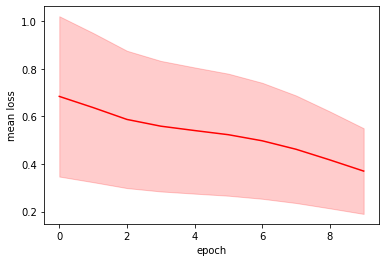

In [3]:
stats = []                                  # Initialisiert eine leere Liste, in der die Ergebnisse akkumuliert werden
for epoch, result in enumerate(trainer.train_classifier(), start=1):   # Trainiert das Modell
    print("epoch=%s E[loss]=%.3f Var[loss]=%.3f" % (str(epoch).zfill(3), result["meanloss"], result["varloss"]))
    stats.append(result)                    # Akkumuliert Zwischenergebnisse
fig, ax = plt.subplots(1, 1)
dwf.plot_training_progress(stats, ax)           # Plotted die Zwischenergebnisse

Der Trainingsfortschritt über die Epochen - je niedriger, desto weniger Fortschritt wird in jeder Iteration erzielt. Das ist ein Zeichen dafür, dass die Güte der Parameter zu einem lokalen Minimum konvergiert.

---

## Plotten der Confusion Matrix
Die "Confusion Matrix" zeigt an, wie oft das Modell welche Klassen miteinander verwechselt. Die Einträge können als Wahrscheinlichkeiten verstanden werden. Beispielsweise ist der obere rechte Eintrag die Wahrscheinlichkeit, dass das Modell eine Wasser-Waveform bekommt und diese dann als "Land" klassifiziert.

Text(0.5, 1.0, 'Confusion Matrix des trainierten Modells')

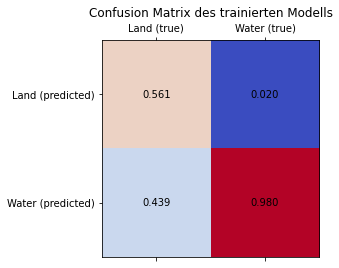

In [4]:
fig, ax = plt.subplots(1, 1)
dwf.plot_confusion_matrix(model, ax, test_ds, class_label_mapping=["Land", "Water"])
ax.set_title("Confusion Matrix des trainierten Modells")

## Speichern und Laden des Modells

In [5]:
torch.save(model.state_dict(), "trained_models/classifier.pt")      # Speichert die Parameter des Modells

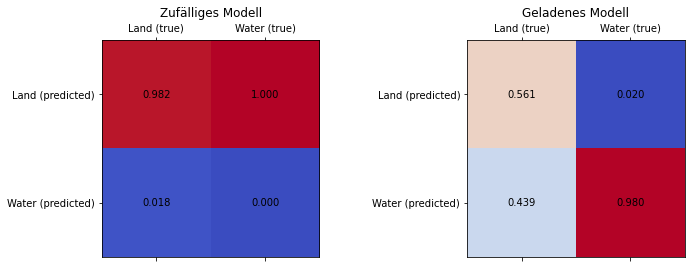

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_title("Zufälliges Modell")
ax2.set_title("Geladenes Modell")
loaded_model = dwf.ConvNet(output_dimension=2)                      # Erstellt ein neues Modell mit zufälligen Parametern
dwf.plot_confusion_matrix(loaded_model, ax1, test_ds)               # ...das nicht besonders gut zwischen Land und Wasser unterscheiden kann
loaded_model.load_state_dict(
    torch.load("trained_models/classifier.pt"))                     # lädt die gespeicherten Parameter in das neue Modell
loaded_model.eval()
dwf.plot_confusion_matrix(loaded_model, ax2, test_ds)               # ...welches im Anschluss deutlich besser klassifizieren kann.

## Datensatz prozessieren
Wir können das trainierte Modell auf einen unbekannten Datensatz ansetzen und so Vorhersagen über die Objektklassen treffen. 

In [7]:
unknown_df = dwf.load_dataset("../data/mit_uferuebergang.txt")

loaded_model.annotate_dataframe(unknown_df,                                      # Der Datensatz, der annotiert werden soll
                                wv_cols=list(range(64)),                         # Die Spaltennamen, die die Waveform angeben
                                class_label_mapping=["Land", "Water"],           # Zu den Klassen korrepondierende Labelnamen
                                predicted_column="Predicted")                    # Spaltenname für wahrscheinlichste Klasse
unknown_df

,id,class,x,y,z,0,1,2,3,4,...,57,58,59,60,61,62,63,Predicted,Land,Water
0,1114,1,-19.952490,-112.538942,0.137429,149,145,146,142,150,...,141,150,143,155,146,145,142,1,0.293834,0.706166
1,1115,1,-19.855479,-112.473813,0.126430,146,140,146,144,149,...,150,143,142,149,145,144,144,1,0.261947,0.738053
2,1117,1,-19.655191,-112.334737,0.091433,145,142,145,142,148,...,144,144,146,151,137,144,144,1,0.317501,0.682499
3,1118,1,-19.548943,-112.261880,0.072435,146,147,149,144,146,...,140,147,146,148,147,150,143,1,0.317320,0.682680
4,1119,1,-20.005788,-113.214739,0.051417,151,151,148,142,150,...,143,147,142,155,150,151,142,1,0.295310,0.704690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274042,418298,0,12.159306,107.994762,1.815527,145,146,144,140,150,...,162,162,155,161,150,156,151,0,0.992943,0.007057
274043,418300,0,12.160348,107.029162,1.792543,158,147,145,140,152,...,156,163,157,163,153,165,151,0,0.993554,0.006446
274044,418301,0,12.269424,107.062909,1.745542,148,137,140,137,147,...,211,204,186,171,167,175,168,0,0.999265,0.000735
274045,418302,0,12.400174,107.051983,1.856542,142,138,144,149,144,...,147,135,150,141,142,142,146,0,0.502328,0.497672


## Vom Modell klassifizierten Datensatz anzeigen lassen
Die Farben der verschiedenen Klassen können angegeben werden. Abhängig von der Sicherheit des Modells werden die Farben (linear) interpoliert.

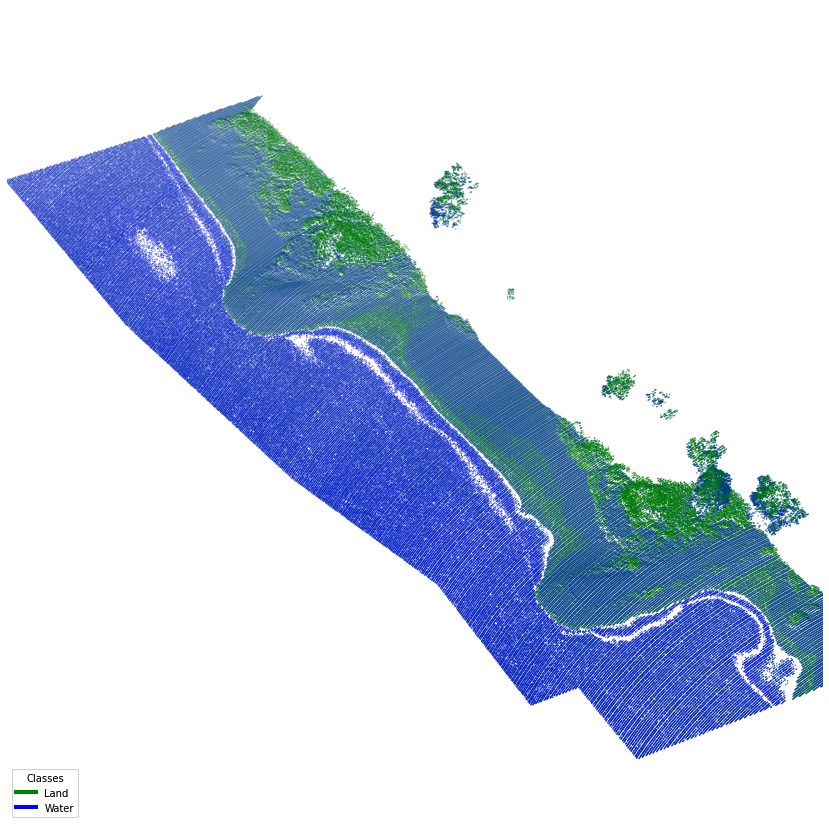

In [8]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
dwf.plot_pcl_prediction(unknown_df,                                 # Der geladene Datensatz
                        ax,                                         # Die Achse, auf der geplottet werden soll
                        probabilities_col=["Land", "Water"],        # Spalten, die die Modellvorhersage zu den entsprechenden Klassen enthalten
                        colors=["green","blue"],                    # Farben, die den Klassen gegeben werden sollen
                        xcol="x",                                   # Spalten, die x,y und z-Positionen der Punkte enthalten
                        ycol="y",
                        zcol="z")